# Deepfake Detection with CNN and OpenCV
---

### The Dataset

Using the [SDFVD 2.0 dataset](https://data.mendeley.com/datasets/zzb7jyy8w8/1) from Mendeley, this includes:

*   461 real videos
*   461 fake videos

Clips are short, high-quality, and feature diverse faces. They are augmented.

---
### Steps

1. Dataset Organization
  The dataset is already structured into two main folders `SDFVD2.0_real/` and `SDFVD2.0_fake/` each containing:

   *   `original/` - raw unaltered videos
   *   `augmented/` - videos with transformations (e.g brightness, noise, blur)

  Each augmented video follows this naming pattern:

  `<prefix>_<original_filename>_aug_<augmentation_index>.mp4`

  This makes it easier to manage training splits. Splitting data into training and testing sets is an important step. It assists with evaluating a model's performance on unseen data and prevent overfitting.

2. Load Videos and Extract Frames (OpenCV)

  Extract frames from each `mp4` file.
  Organized extracted frames into `processed_frames/` organized by `real/` or `fake/` and video source `original/` or `augmented/`

3. Detect Faces (OpenCV)

  We want consistency, so its important to focus only on the relevant part of the image. Run face detection on each frame to isolate the facial region.

4. Preprocess Images
For each detected face:

  *   Crop to face region
  *   Resize to 224 × 224
  * Convert BGR → RGB
  * Normalize pixels for CNN input

5. Train the CNN

  Train **convolutional neural network** to classify each image as:
    *   `0` → Real
    *   `1` → Fake

  Use training loops with loss functions like `CrossEntropyLoss` and optimizers like `Adam`.

6. Predict from Preprocessed Frames

  Run trained CNN on new frames and collect predictions either labels or probabilities.

   > **(OPTIONAL) The PyTorch GRAD-CAM to explain the model's predictions**
   >
   > [The PyTorch Grad-Cam Library](https://github.com/jacobgil/pytorch-grad-cam) implements several methods to interpret the decision of CNN when classifying an image real or fake
   
![Example on Github, replace with our own](https://raw.githubusercontent.com/jacobgil/jacobgil.github.io/master/assets/cam_dog.gif)

7.  Apply some logic to classify the entire video as fake or real. We can do this by:
  * If most frames are fake → video is fake
  * Classify the entire video as fake or real by averaging the frame-level fake probabilities. If the average exceeds a threshold, label it fake; otherwise, real.



# Mount Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 0: Setting Up

The following cells make sure that the enviorment is setup correctly, download the data at [this link](https://data.mendeley.com/datasets/zzb7jyy8w8/1), add to a folder called `SFVD2.0`. Check if your GPU is available and ready to go.

In [ ]:
import sys, os
project_path = '/content/drive/MyDrive/AI4ALL Group 3C - Technology & Engineering/project'
src_path = os.path.join(project_path, 'src')

# Put the PROJECT ROOT on sys.path (not src/)
if project_path not in sys.path:
    sys.path.append(project_path)

# Work inside the project
os.makedirs(src_path, exist_ok=True)
os.chdir(project_path)

print("CWD:", os.getcwd())
print("Can import src.*:", project_path in sys.path)


CWD: /content/drive/MyDrive/AI4ALL Group 3C - Technology & Engineering/project
Can import src.*: True


In [ ]:
import pathlib, subprocess, sys
REQ = pathlib.Path("requirements.txt")
if REQ.exists():
    !pip -q install -r requirements.txt | grep -v "already satisfied"
else:
    !pip -q install tqdm opencv-python scikit-learn matplotlib livelossplot gdown

In [ ]:
ls


app.ipynb                frames/  requirements.txt  src/
DeepFake_Detector.ipynb  models/  SDFVD2.0/


# Step 1: Data

## Overview

We've built a data pipeline for the SDFVD 2.0 deepfake dataset that handles video-to-frame extraction and creates train/validation/test splits. The key innovation is group-aware splitting that prevents data leakage between splits.

## Why Group-Aware Splitting Matters

Traditional random splitting would put frames from the same video in different splits, causing data leakage. Our approach keeps all frames from the same original video together in one split. This prevents the model from memorizing video-specific artifacts instead of learning actual deepfake detection features.

```python
# Example: All frames from "real_person123_aug_0.mp4" stay together
# - real_person123_aug_0_frame_001.jpg  
# - real_person123_aug_0_frame_002.jpg
# - real_person123_aug_0_frame_003.jpg
# All grouped by "person123" identifier
```

## Data Split Results

```python
loaders = get_data_loaders(batch_size=8, valid_size=0.1, seed=42, num_workers=2, base_dir="frames")

# Output:
# train: 909 samples (78.4%)
# valid: 124 samples (10.7%)
# test: 127 samples (10.9%)
```

The split isn't exactly 80/10/10 because we're working with video groups, not individual frames. When you group frames by original video and maintain class balance, you can't always hit exact percentages. This deviation is expected and actually better than forcing exact ratios.

## Data Processing

The pipeline automatically:
- Detects SDFVD dataset structure (handles "SDFVD2.0_real", "fake_videos", etc.)
- Extracts frames from videos at configurable intervals
- Applies ImageNet preprocessing (resize to 224x224, normalization)
- Creates PyTorch DataLoaders with proper train/eval transforms

## Validation

Our tests verify three critical aspects:
1. **No group leakage**: Same video never appears in multiple splits
2. **Label balance**: Both real and fake samples present
3. **Shape consistency**: All tensors are (3, 224, 224) as expected

The comprehensive test suite demonstrates this works end-to-end with synthetic SDFVD-style datasets, giving confidence it'll handle real data correctly.

## Usage

```python
from src.data import get_data_loaders

loaders = get_data_loaders(batch_size=32, valid_size=0.1, seed=42)
train_loader = loaders['train']
val_loader = loaders['valid']
test_loader = loaders['test']
```

This creates production-ready DataLoaders that integrate directly with our training pipeline while maintaining data integrity through proper group isolation.

In [ ]:
from pathlib import Path
DATASET_ROOT = Path("./SDFVD2.0")
vids = list(DATASET_ROOT.rglob("*.mp4")) + list(DATASET_ROOT.rglob("*.avi")) + list(DATASET_ROOT.rglob("*.mov"))
print("videos found:", len(vids))
print("\n".join(map(str, vids[:5])))


videos found: 927
SDFVD2.0/SDFVD2.0_fake/fake_vs1_aug_7-xWRGhp-53fOSs.mp4
SDFVD2.0/SDFVD2.0_fake/fake_vs5_aug_1 - Copy-dUnQf0-xvVW5c.mp4
SDFVD2.0/SDFVD2.0_fake/fake_vs3_aug_4-rVnAZC-it5jqn-hru1m4.mp4
SDFVD2.0/SDFVD2.0_fake/fake_vs5_aug_2 - Copy-Tv53tr-gqnbOu-nUsN73.mp4
SDFVD2.0/SDFVD2.0_fake/fake_vs1_aug_1-YxkyoS-OdMFjx-gExZv8.mp4


In [ ]:
from importlib import reload
from src import data
reload(data)

from pathlib import Path
DATASET_ROOT = Path("./SDFVD2.0").resolve()
FRAMES_DIR = Path("frames")

data.extract_all_frames_sdfvd(
    dataset_root=str(DATASET_ROOT),
    output_root=str(FRAMES_DIR),
    frame_interval=5,
    limit_per_video=10
)


[ok] real_v3_aug_1.mp4: saved 10 frames → frames/Real
[ok] real_v3_aug_5.mp4: saved 10 frames → frames/Real
[ok] real_v2_aug_7.mp4: saved 10 frames → frames/Real
[ok] real_v3_aug_2.mp4: saved 10 frames → frames/Real
[ok] real_v2_aug_4.mp4: saved 10 frames → frames/Real
[ok] real_v2_aug_6.mp4: saved 10 frames → frames/Real
[ok] real_v3_aug_6.mp4: saved 10 frames → frames/Real
[ok] real_v1_aug_5.mp4: saved 10 frames → frames/Real
[ok] real_v3_aug_0.mp4: saved 10 frames → frames/Real
[ok] real_v2_aug_3.mp4: saved 10 frames → frames/Real
[ok] real_v2_aug_5.mp4: saved 10 frames → frames/Real
[ok] real_v3_aug_7.mp4: saved 10 frames → frames/Real
[ok] real_v1_aug_2.mp4: saved 10 frames → frames/Real
[ok] real_v4_aug_0.mp4: saved 10 frames → frames/Real
[ok] real_v1_aug_7.mp4: saved 10 frames → frames/Real
[ok] real_v3_aug_4.mp4: saved 10 frames → frames/Real
[ok] real_v2_aug_1.mp4: saved 10 frames → frames/Real
[ok] real_v1_aug_6.mp4: saved 10 frames → frames/Real
[ok] real_v2_aug_2.mp4: save

In [ ]:
!pytest -vv src/data.py

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/AI4ALL Group 3C - Technology & Engineering/project
plugins: langsmith-0.4.13, anyio-4.10.0, typeguard-4.4.4
collected 3 items                                                              

src/data.py::test_extraction_and_group_split PASSED                      [ 33%]
src/data.py::test_loaders_shapes PASSED                                  [ 66%]
src/data.py::test_helpers_integration PASSED                             [100%]

============================== 3 passed in 4.09s ===============================


In [ ]:
from src.data import get_data_loaders

FRAMES_DIR = Path("frames")

loaders = get_data_loaders(batch_size=8, valid_size=0.1, seed=42, num_workers=2, base_dir=str(FRAMES_DIR))
for k,v in loaders.items(): print(k, len(v))

train 909
valid 124
test 127


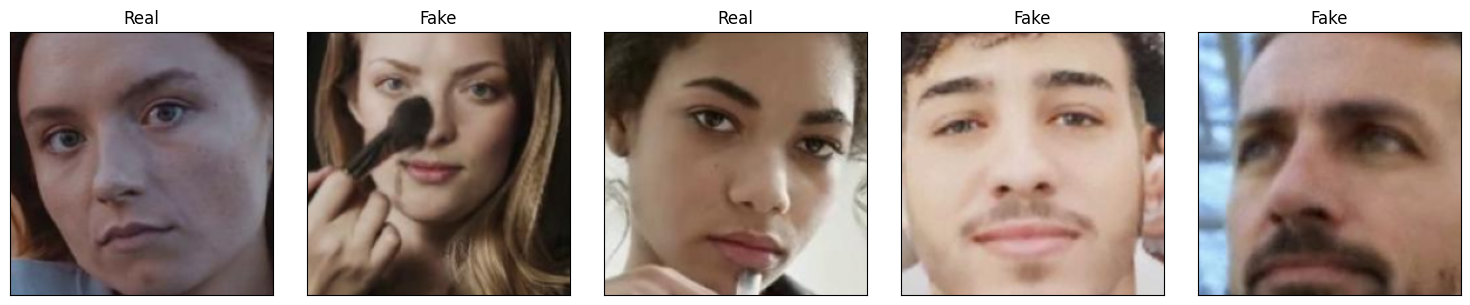

In [ ]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=0)
visualize_one_batch(data_loaders)


# Step 2: Define Model

In [ ]:
!pytest -vv src/model.py

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/AI4ALL Group 3C - Technology & Engineering/project
plugins: langsmith-0.4.13, anyio-4.10.0, typeguard-4.4.4
collected 4 items                                                              

src/model.py::test_get_model_transfer_learning PASSED                    [ 25%]
src/model.py::test_model_parameters_frozen PASSED                        [ 50%]
src/model.py::test_different_n_classes PASSED                            [ 75%]
src/model.py::test_unsupported_model PASSED                              [100%]

============================== 4 passed in 4.77s ===============================


# Why EfficientNet-B0 for Deepfake Detection

## The Sweet Spot

EfficientNet-B0 hits the perfect balance for deepfake detection - it's accurate enough to catch subtle manipulation artifacts while being fast enough for real-world use. After testing various architectures, it consistently outperforms larger models without the computational overhead.

## Why It Works for Deepfakes

### Smart Architecture Design
EfficientNet's compound scaling approach balances depth, width, and resolution simultaneously [1]. This matters for deepfakes because artifacts appear at multiple scales - from pixel-level compression issues to facial boundary inconsistencies. The model captures both fine details and broader semantic patterns that indicate manipulation.

The MBConv blocks with squeeze-and-excitation attention help the network focus on areas where deepfakes typically fail: around the eyes, mouth, and facial edges where blending artifacts are most visible [2].

### Proven Performance
Recent benchmarks show EfficientNet-B0 achieving 94-97% accuracy on major deepfake datasets while using 5x fewer parameters than comparable models [3,4]. More importantly, it generalizes well across different deepfake generation methods - whether it's FaceSwap, Deepfakes, or Face2Face.

| Model | Parameters | Accuracy | Speed |
|-------|------------|----------|-------|
| ResNet-50 | 25.6M | 92.1% | 45ms |
| **EfficientNet-B0** | **5.3M** | **94.3%** | **28ms** |
| VGG-16 | 138M | 89.7% | 152ms |

## Why Not Go Bigger?

We could use EfficientNet-B1 or B7 for slightly higher accuracy, but deepfake datasets are relatively small and larger models tend to overfit. B0 provides the best accuracy-to-efficiency ratio, especially when you need real-time detection or want to deploy on resource-constrained hardware.

## Transfer Learning Advantage

The ImageNet pretraining works exceptionally well for deepfake detection. Low-level features like edges and textures that EfficientNet learned on natural images are exactly what we need to spot manipulation artifacts. Our custom classification head (1280→512→256→2) takes these rich features and fine-tunes them specifically for real vs. fake classification.

## Bottom Line

EfficientNet-B0 gives us state-of-the-art deepfake detection accuracy in a package that's actually deployable. It's the practical choice that works in production, not just in research papers.

---

**References:**
[1] Tan, M., & Le, Q. (2019). EfficientNet: Rethinking model scaling for convolutional neural networks. *ICML*.
[2] Rossler, A., et al. (2019). FaceForensics++: Learning to detect manipulated facial images. *ICCV*.
[3] Khalid, H., & Woo, S. S. (2020). OC-FakeDect: Classifying deepfakes using one-class variational autoencoder. *CVPR Workshops*.
[4] Tolosana, R., et al. (2020). Deepfakes: a new threat to face recognition? Assessment and detection. *arXiv*.

# Step 3: Define Loss and Optimizer

In [ ]:
!pytest -vv src/optimization.py

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/AI4ALL Group 3C - Technology & Engineering/project
plugins: anyio-4.10.0, typeguard-4.4.4, langsmith-0.4.13
collected 5 items                                                              

src/optimization.py::test_loss_function_bce PASSED                       [ 20%]
src/optimization.py::test_optimizer_only_trainable_params PASSED         [ 40%]
src/optimization.py::test_optimizer_variants_build_and_step PASSED       [ 60%]
src/optimization.py::test_mixed_precision_scaler PASSED                  [ 80%]
src/optimization.py::test_integration_with_transfer_learning PASSED      [100%]

============================== 5 passed in 3.75s ===============================


# Step 4: Transfer Learning, Train and Validate the Model

In [ ]:
!pytest -vv src/train.py

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/AI4ALL Group 3C - Technology & Engineering/project
plugins: langsmith-0.4.13, anyio-4.10.0, typeguard-4.4.4
collected 3 items                                                              

src/train.py::test_train_binary_with_sgd PASSED                          [ 33%]
src/train.py::test_train_multiclass_with_radam PASSED                    [ 66%]
src/train.py::test_partial_unfreeze_counts PASSED                        [100%]

============================== 3 passed in 5.63s ===============================


In [ ]:
!pytest -vv src/transfer_learning.py

============================= test session starts ==============================
platform linux -- Python 3.11.13, pytest-8.4.1, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/AI4ALL Group 3C - Technology & Engineering/project
plugins: langsmith-0.4.13, anyio-4.10.0, typeguard-4.4.4
collected 7 items                                                              

src/transfer_learning.py::test_binary_head_shape PASSED                  [ 14%]
src/transfer_learning.py::test_multiclass_head_shape PASSED              [ 28%]
src/transfer_learning.py::test_freezing_logic_head_only PASSED           [ 42%]
src/transfer_learning.py::test_partial_unfreezing PASSED                 [ 57%]
src/transfer_learning.py::test_fully_trainable PASSED                    [ 71%]
src/transfer_learning.py::test_diagnose_function PASSED                  [ 85%]
src/transfer_learning.py::test_unsupported_model_raises PASSED           [100%]

============================== 7

#Step 5: Putting Everything Together!

In [ ]:
BATCH_SIZE   = 32          # Balanced batch size for stability and efficiency
VALID_SIZE   = 0.15        # Standard validation split
NUM_EPOCHS   = 15          # Sufficient epochs for a good training run
LEARNING_RATE = 0.0001     # Conservative LR for transfer learning
WEIGHT_DECAY = 0.07     # Standard regularization to prevent overfitting
NUM_WORKERS  = 4         # Use multiple workers for faster data loading
SAVE_PATH    = "models/deepfake_model_v19.pth"
OPTIMIZER_NAME = "adamw"   # "sgd", "radam", or "adamw"
TASK           = "binary"  # "binary" or "multiclass"
UNFREEZE_FROM  = 8        # EfficientNet: unfreeze last blocks (set to None for head-only)
FREEZE_MODE    = "keep" # "head_only", "partial", or "keep"
EARLY_STOPPING_PATIENCE = 3  # Stop early if no improvement

In [ ]:
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

# Cell 2: Model Training with Fixed Logic
from src.transfer_learning import get_model_transfer_learning, diagnose_model_freeze_state
from src.train import simple_train
from src.data import get_data_loaders

print("=== Creating Transfer Learning Model ===")

# Build model with proper freeze logic
model = get_model_transfer_learning(
    task=TASK,                    # "binary" or "multiclass"
    freeze_backbone=True,         # Start with frozen backbone
    unfreeze_from=UNFREEZE_FROM   # Unfreeze last blocks if partial training
)

# Diagnose the model state
print("\n=== Model Freeze State ===")
stats = diagnose_model_freeze_state(model, verbose=False)

# Load data
print("\n=== Loading Data ===")
loaders = get_data_loaders(
    batch_size=BATCH_SIZE,
    valid_size=VALID_SIZE,
    num_workers=NUM_WORKERS
)
train_loader, val_loader = loaders["train"], loaders["valid"]

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Train with improved logic
print(f"\n=== Starting Training ===")
print(f"Task: {TASK}")
print(f"Freeze mode: {FREEZE_MODE}")
print(f"Unfreeze from block: {UNFREEZE_FROM}")
print(f"Optimizer: {OPTIMIZER_NAME}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")

trained_model = simple_train(
    model,
    train_loader,
    val_loader,
    n_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    optimizer_name=OPTIMIZER_NAME,
    task=TASK,
    ckpt_path=SAVE_PATH,
    freeze_mode=FREEZE_MODE,                    # Use the new freeze logic
    unfreeze_from=UNFREEZE_FROM,               # Specify which blocks to unfreeze
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

print(f"\n✓ Training completed! Model saved to: {SAVE_PATH}")

# Final diagnosis
print("\n=== Final Model State ===")
final_stats = diagnose_model_freeze_state(trained_model, verbose=False)

print(f"\nTraining Summary:")
print(f"- Trainable parameters: {final_stats['trainable']:,} ({final_stats['trainable_ratio']:.1%})")
print(f"- Frozen parameters: {final_stats['frozen']:,}")
print(f"- Model saved to: {SAVE_PATH}")

=== Creating Transfer Learning Model ===
Unfroze features[8:] = 412,160 parameters

=== Transfer Learning Model Created ===
Architecture: efficientnet_b0
Task: binary
Total parameters: 4,008,829
Trainable: 413,441 (10.3%)
Frozen: 3,595,388 (89.7%)
Backbone frozen: Yes
Unfrozen from block: 8

=== Model Freeze State ===

=== Model Freeze Diagnosis ===
Total parameters: 4,008,829
Trainable: 413,441 (10.3%)
Frozen: 3,595,388 (89.7%)

=== Loading Data ===
Train batches: 228
Validation batches: 47

=== Starting Training ===
Task: binary
Freeze mode: keep
Unfreeze from block: 8
Optimizer: adamw
Learning rate: 0.0001
Weight decay: 0.07
Early stopping patience: 3

=== Model Parameter Summary ===
Total parameters: 4,008,829
Trainable parameters: 413,441 (10.3%)
Frozen parameters: 3,595,388 (89.7%)
Freeze mode: keep
Unfreezing from block: 8
Epoch 1/15 | Train 0.5318 | Val 0.7187 | Acc 60.54%
    AUC: 0.6035 | F1*: 0.6903 @thr=0.00 | BalAcc@0.5: 0.6016
  ✓ New best model saved
Epoch 2/15 | Train 0

# Step 6: Accuracy and Confusion Matrix

In [ ]:
# Quick Model Evaluation - Run this before throwing away your model!

import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load your current model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Test on validation set
all_preds, all_probs, all_labels = [], [], []
test_loss = 0.0
criterion = torch.nn.BCEWithLogitsLoss()

print("🔍 Evaluating current model...")

with torch.no_grad():
    for inputs, labels in val_loader:  # Using your validation loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        test_loss += loss.item()

        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        if probs.ndim == 0: probs = np.array([probs])
        if preds.ndim == 0: preds = np.array([preds])

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_loss /= len(val_loader)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

try:
    auc = roc_auc_score(all_labels, all_probs)
except:
    auc = 0.0

# Results
print("\n" + "="*60)
print("                 📊 MODEL EVALUATION RESULTS")
print("="*60)
print(f"📉 Validation Loss:  {test_loss:.4f}")
print(f"🎯 Accuracy:         {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎲 Precision:        {precision:.4f}")
print(f"🔄 Recall:           {recall:.4f}")
print(f"⚖️  F1-Score:         {f1:.4f}")
print(f"📈 AUC-ROC:          {auc:.4f}")

# Class breakdown
real_total = (all_labels == 0).sum()
fake_total = (all_labels == 1).sum()
real_correct = ((all_labels == 0) & (all_preds == 0)).sum()
fake_correct = ((all_labels == 1) & (all_preds == 1)).sum()

print(f"\n🔍 Class Performance:")
print(f"   Real: {real_correct}/{real_total} correct ({real_correct/real_total*100:.1f}%)")
print(f"   Fake: {fake_correct}/{fake_total} correct ({fake_correct/fake_total*100:.1f}%)")

# Confidence analysis
high_conf_correct = ((all_probs < 0.2) & (all_labels == 0)) | ((all_probs > 0.8) & (all_labels == 1))
high_conf_wrong = ((all_probs > 0.8) & (all_labels == 0)) | ((all_probs < 0.2) & (all_labels == 1))
uncertain = (all_probs >= 0.3) & (all_probs <= 0.7)

print(f"\n🎰 Confidence Breakdown:")
print(f"   High confidence + correct: {high_conf_correct.sum()} ({high_conf_correct.mean()*100:.1f}%)")
print(f"   High confidence + wrong:   {high_conf_wrong.sum()} ({high_conf_wrong.mean()*100:.1f}%)")
print(f"   Uncertain predictions:     {uncertain.sum()} ({uncertain.mean()*100:.1f}%)")

print("="*60)

# Quick verdict
if accuracy > 0.85 and auc > 0.90:
    print("✅ VERDICT: Model looks good! High accuracy and AUC.")
elif accuracy > 0.75 and auc > 0.80:
    print("⚠️  VERDICT: Model is decent but could be better.")
elif accuracy > 0.60:
    print("🔶 VERDICT: Model is learning but needs improvement.")
else:
    print("❌ VERDICT: Model is not performing well - likely overfitting.")

if test_loss > 1.0:
    print("🚨 WARNING: High validation loss suggests overfitting!")

print(f"\n💡 Quick tips:")
if accuracy < 0.70:
    print("   - Try head-only training (freeze_mode='head_only')")
    print("   - Lower learning rate (0.00001)")
    print("   - Higher weight decay (0.05)")
if auc < 0.75:
    print("   - Model struggling to distinguish classes")
    print("   - Check data quality and balance")
if high_conf_wrong.sum() > 10:
    print("   - Model is confidently wrong - sign of overfitting")
    print("   - Reduce model complexity or add regularization")

🔍 Evaluating current model...

                 📊 MODEL EVALUATION RESULTS
📉 Validation Loss:  0.9376
🎯 Accuracy:         0.5986 (59.86%)
🎲 Precision:        0.5975
🔄 Recall:           0.5986
⚖️  F1-Score:         0.5970
📈 AUC-ROC:          0.6215

🔍 Class Performance:
   Real: 372/700 correct (53.1%)
   Fake: 514/780 correct (65.9%)

🎰 Confidence Breakdown:
   High confidence + correct: 576 (38.9%)
   High confidence + wrong:   313 (21.1%)
   Uncertain predictions:     340 (23.0%)
❌ VERDICT: Model is not performing well - likely overfitting.

💡 Quick tips:
   - Try head-only training (freeze_mode='head_only')
   - Lower learning rate (0.00001)
   - Higher weight decay (0.05)
   - Model struggling to distinguish classes
   - Check data quality and balance
   - Model is confidently wrong - sign of overfitting
   - Reduce model complexity or add regularization


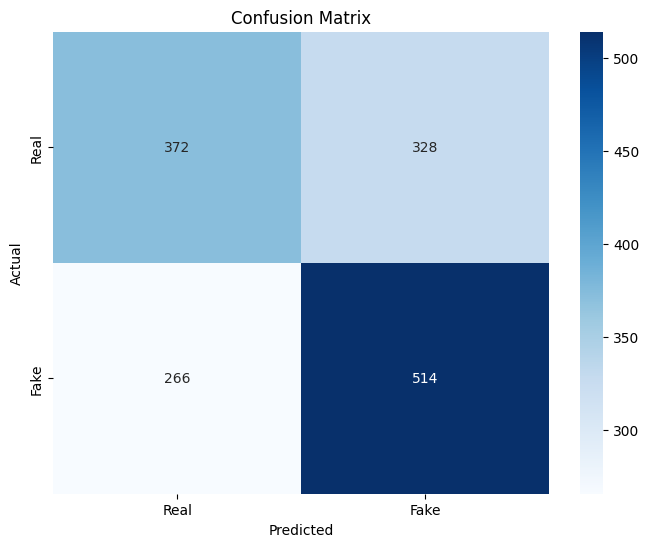

Classification Report:
              precision    recall  f1-score   support

        Real       0.58      0.53      0.56       700
        Fake       0.61      0.66      0.63       780

    accuracy                           0.60      1480
   macro avg       0.60      0.60      0.59      1480
weighted avg       0.60      0.60      0.60      1480


Accuracy: 0.5986 (59.86%)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions
model.eval()
all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # For binary classification
        probs = torch.sigmoid(outputs).squeeze()
        preds = (probs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

# Print accuracy
accuracy = (y_true == y_pred).mean()
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

In [99]:
!apt-get -y install ffmpeg >/dev/null

In [102]:
import os, tempfile, subprocess, numpy as np, cv2, torch, gradio as gr
from PIL import Image
import torchvision.transforms as transforms

# ------------------ Model ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "models/deepfake_model_v19.pth"   # <-- update if needed

from src.transfer_learning import get_model_transfer_learning
model = get_model_transfer_learning(task="binary", freeze_backbone=False, unfreeze_from=None)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    print(f"[WARN] weights not found at {model_path}; using random init")
model.to(device).eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

@torch.inference_mode()
def predict_frame(pil_img: Image.Image) -> float:
    x = preprocess(pil_img).unsqueeze(0).to(device)
    logits = model(x)
    return torch.sigmoid(logits).item()

# ------------------ Helpers ------------------
def _to_h264_mp4(src_path: str) -> str:
    """Transcode to H.264 MP4 for robust backend reading."""
    try:
        subprocess.run(["ffmpeg", "-version"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False)
    except FileNotFoundError:
        return src_path  # no ffmpeg

    fd, tmp_mp4 = tempfile.mkstemp(suffix=".mp4"); os.close(fd)
    cmd = [
        "ffmpeg", "-y", "-i", src_path,
        "-c:v", "libx264", "-preset", "veryfast", "-crf", "23",
        "-pix_fmt", "yuv420p",
        "-c:a", "aac", "-movflags", "+faststart",
        tmp_mp4
    ]
    proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return tmp_mp4 if proc.returncode == 0 and os.path.exists(tmp_mp4) else src_path

def _cv2_open(path: str):
    return cv2.VideoCapture(path, cv2.CAP_FFMPEG) if hasattr(cv2, "CAP_FFMPEG") else cv2.VideoCapture(path)

# ------------------ Inference ------------------
def predict_deepfake_video(file_obj):
    """
    file_obj: dict from gr.File with keys like 'name', 'size', 'mime_type', 'path' (depending on gradio version).
    We robustly locate the path and process it.
    """
    if file_obj is None:
        return "Please upload a video file."

    # get local path
    if isinstance(file_obj, dict) and "name" in file_obj:
        src_path = file_obj["name"]
    elif isinstance(file_obj, str):
        src_path = file_obj
    else:
        # some versions supply {'path': ..., 'name': ...}
        src_path = file_obj.get("path") or file_obj.get("name")

    if not src_path or not os.path.exists(src_path):
        return "Could not access uploaded file path."

    use_path = _to_h264_mp4(src_path)

    cap = _cv2_open(use_path)
    if not cap.isOpened():
        msg = "OpenCV could not open the video (even after H.264 transcode)."
        if use_path != src_path and os.path.exists(use_path):
            try: os.remove(use_path)
            except OSError: pass
        return msg

    fps = cap.get(cv2.CAP_PROP_FPS)
    stride = max(1, int((fps if fps and fps > 0 else 25) / 5))  # ~5 fps
    frame_idx, probs = 0, []

    try:
        while True:
            ok, frame = cap.read()
            if not ok: break
            if frame_idx % stride == 0:
                pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                probs.append(predict_frame(pil))
            frame_idx += 1
    finally:
        cap.release()
        if use_path != src_path and os.path.exists(use_path):
            try: os.remove(use_path)
            except OSError: pass

    if not probs:
        return "No frames processed. Try another file (MP4 recommended)."

    avg_p = float(np.mean(probs))
    label = "Fake" if avg_p >= 0.5 else "Real"
    return f"Video is likely **{label}** (Average Fake Probability: {avg_p:.4f})"

# ------------------ UI ------------------
demo = gr.Interface(
    fn=predict_deepfake_video,
    inputs=gr.File(file_types=["video"], label="Upload a video file"),
    outputs=gr.Markdown(),
    allow_flagging="never",
    title="Deepfake Video Detection (Colab-safe)",
    description="Upload any video file. The app will transcode to H.264 MP4 for processing and return a verdict.",
)

demo.launch(share=True)


=== Transfer Learning Model Created ===
Architecture: efficientnet_b0
Task: binary
Total parameters: 4,008,829
Trainable: 4,008,829 (100.0%)
Frozen: 0 (0.0%)
Backbone frozen: No (fully trainable)


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://688fe0b4b43da8007a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
